In [69]:
import pandas as pd
import numpy as np

import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, silhouette_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, chi2

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

from scipy.stats import chi2_contingency, multinomial
from scipy.sparse import hstack, csr_matrix

import nltk
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize, RegexpTokenizer, regexp_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, LancasterStemmer, PorterStemmer
from nltk.probability import FreqDist
from nltk import WordNetLemmatizer, pos_tag
from nltk.util import bigrams
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
#nltk.download('all')
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.metrics import BigramAssocMeasures

import itertools
import string
import contractions

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from copy import deepcopy

from xgboost import XGBClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/emmascotson/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Loading the Data

Let's load our dataset and take a look at it.

In [2]:
data = pd.read_csv('data/Combined Data.csv')

In [3]:
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


Looks like we have some NaNs. Let's take a closer look.

In [5]:
data[pd.isna(data['statement'])]

,Unnamed: 0,statement,status
293,293,NaN,Anxiety
572,572,NaN,Anxiety
595,595,NaN,Anxiety
1539,1539,NaN,Normal
2448,2448,NaN,Normal
...,...,...,...
52838,52838,NaN,Anxiety
52870,52870,NaN,Anxiety
52936,52936,NaN,Anxiety
53010,53010,NaN,Anxiety


There are so few NaN's compared to the number of rows in our entire dataframe. Furthermore, rows with no 'statement' value are useless to us. Let's drop them.

In [6]:
data = data.dropna(subset=['statement'])

Now let's check if there are duplicate rows. 

In [7]:
data['statement'].nunique()

51073

It looks like there are!

In [8]:
data[data['statement'].duplicated()]

,Unnamed: 0,statement,status
97,97,"""No regrets or grudges/angry at things that ha...",Anxiety
138,138,but my heart is still restless even though my ...,Anxiety
167,167,I want to exhale the restlessness in my chest ...,Anxiety
228,228,Do not compare yourself to others. Envy only m...,Anxiety
244,244,"people seem calm, happy like there's no proble...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


These statements all look pretty specific and personalized. AKA it does seem like our duplicate values are true duplicates of the same social media statements made by the same singular user. Furthermore, we have over 50,000 rows in our dataset and can afford to lose these rows. 

Let's drop duplicates as well.

In [9]:
# Removing 'statement' duplicates, keeping first instance
data = data.drop_duplicates(subset=['statement'], keep='first')

In [10]:
data[data['statement'].duplicated()]

,Unnamed: 0,statement,status


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51073 entries, 0 to 52840
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  51073 non-null  int64 
 1   statement   51073 non-null  object
 2   status      51073 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


Furthermore, our 'Unnamed: 0' column appears to just be a duplicate of our index. Let's explore. 

In [12]:
data['Unnamed: 0'].nunique()

51073

In [13]:
# Checking if 'Unnamed: 0' equals our index
is_identical = data['Unnamed: 0'].equals(data.index)
is_identical

False

Hm...We can safely assume this column doesn't provide information about multiple 'statement' values being generated by the same singular user...because our nunique() matches the total number of rows in our dataframe, which eliminates the possibility of duplicates. 

This column is most likely just an old index from previous datasets, which is no longer useful to use. We'll drop it for now. We can always go back and edit the code if we decide we need it later.

In [14]:
data.drop(columns=['Unnamed: 0'], inplace=True)

Let's look at the value_counts() for our target variable 'status'.

In [15]:
data['status'].value_counts()

status
Normal                  16039
Depression              15087
Suicidal                10641
Anxiety                  3617
Bipolar                  2501
Stress                   2293
Personality disorder      895
Name: count, dtype: int64

#### 'Personality disorder'

'Personality disorder' is an ambiguous label compared to the others. It might be a version of a 'placeholder' value for not 'Normal' users where further categorization of disorder (ex. 'Depression', 'Suicidal', 'Anxiety') was inconclusive. Alternatively, it could be indication of other, entirely different personality disorders not listed above. 

We'll keep this in mind and explore as we go. Depending on what we find, it might be helpful to drop these values when building a predictive model.

# Preprocessing & EDA

## Prior to Cleaning...

We'll want to clean the text in our data by performing operations that remove punctuation and special characters, lowercase text, remove newline '\n' characters, etc.

However, ***before*** we do this...let's look at whether or not we can use any of our 'pre-cleaned' text to create features that might be useful down the road.

#### Percentage Upper-Case

Let's think about whether or not any unique punctuation and/or text characteristics might be indicative of a personality disorder. 

*Upper-case* text might help identify whether or not a person is in some kind of distress. If user posts 'A MESSAGE ENTIRELY IN UPPER-CASE LIKE SO', that's an unusual behavior that we should try and quantify.

Let's create a new column 'perc_upper' that calculates the percentage of upper-case letters to the total number of letters in each 'statement'.

In [16]:
# Define function to calculate percentage of upper-case letters
def perc_upper(text):
    if not isinstance(text, str):
        return 0
    letters = re.findall(r'[a-zA-Z]', text) # Using regex to isolate letters
    if not letters: 
        return 0
    upper_count = len(re.findall(r'[A-Z]', text))
    return (upper_count / len(letters)) * 100

data['perc_upper'] = data['statement'].apply(perc_upper)

In [17]:
upper_sorted = data.sort_values(by='perc_upper', ascending=False)
upper_sorted.head()

,statement,status,perc_upper
3546,[HELP RT] WE FANBASE SHAKE RP! JOIN? FOLLOW FI...,Normal,100.0
2436,ONAKA GA SUITA,Normal,100.0
6787,TODAY NO CLASS YAAYYY,Normal,100.0
5303,6 HALF HOURS AGAINIII ULULU I ​​WANT TO SLEEP ...,Normal,100.0
2478,I DON'T HAVE A HOLIDAY AS WELL AS EVIL,Normal,100.0


#### METRIC CHANGE - Percentage by Upper-Case Words

On second thought, we should find a different way to quantify a notable amount of upper-case in a string of text. With our current 'perc_upper' value...a statement such as 'Hi' will have a 50% perc_upper. However this would be due to normal grammatical capitalization techniques that are of no note.

Let's alter our metric slightly, to calculate the **percentage of upper-case words compared to the total number of words in a statement**.

We'll stick with regex for now to tokenize our words and calculate this metric.

In [18]:
# Dropping perc_upper column before to reduce computation time
data.drop(columns=['perc_upper'], inplace=True)

# Updating perc_upper to calculate based on number of words
def perc_upper_words(text): 
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b[a-zA-Z\'-]+\b', text) # Including apostrophes and hyphens
    words = [word for word in words if not re.search(r'\d', word)] # Filter out numbers
    if not words:
        return 0
    uppercase_words = [word for word in words if word.isupper()]
    return len(uppercase_words) / len(words) * 100

data['perc_upper_words'] = data['statement'].apply(perc_upper_words)

In [19]:
upper_sorted = data.sort_values(by='perc_upper_words', ascending=False)
upper_sorted.head()

,statement,status,perc_upper_words
11210,I KEEP MESSING THINGS UP ALL DAY EVERY DAY THE...,Suicidal,100.0
5917,#PECAT WHOSE NAME IS SI ALI MOCHTAR NYEBELIN #,Normal,100.0
4173,OH MY GOD FEAR CANCEL,Normal,100.0
1581,HIS BD CARD KANON IS CUTE HSHSHSHS SAD NO FREE...,Normal,100.0
2811,YAALLAH SO NATION OF SM DREAMIES,Normal,100.0


In [20]:
# Sampling rows from the middle
filtered_rows = upper_sorted[(upper_sorted['perc_upper_words'] >= 50.0) & (upper_sorted['perc_upper_words'] <= 60.0)]
filtered_rows.head(20)

,statement,status,perc_upper_words
10953,NOBODY WANTS TO TALK TO ME Going to kill myself,Depression,60.000000
498,"the habit of chatting for a day, gadicchat imm...",Anxiety,60.000000
17851,I feel like I cannot even explain myself becau...,Suicidal,60.000000
4525,NOT FUNNY MORNING â€ Runny nose,Normal,60.000000
24841,I try my best but I just want to die. I hate m...,Depression,59.420290
6357,HAHAAAA GET THE ASSIGNMENT OF MAKING A SCIENTI...,Normal,57.894737
1113,WANT TO SIN BUT Afraid to Laugh,Normal,57.142857
36232,Everything is temporary. EVIL EYES OFF SHIVRIT,Normal,57.142857
830,MORNING AGAIN I've made a AMENDE SPACE,Normal,57.142857
48673,AAAAAAAAAAAAAAAAAA aaAAAAAAAAAA FIDBWJSKLA oaa...,Stress,57.142857


Let's see if there are any trends regarding the distribution of these numbers within each of our 'status' values.

In [21]:
upper_stats = data.groupby('status')['perc_upper_words'].agg(['mean', 'min', 'max'])
upper_stats

,mean,min,max
status,,,
Anxiety,5.511061,0.0,100.000000
Bipolar,5.978278,0.0,25.000000
Depression,5.667380,0.0,100.000000
Normal,3.903474,0.0,100.000000
Personality disorder,5.424887,0.0,27.118644
Stress,5.664143,0.0,57.142857
Suicidal,7.922907,0.0,100.000000


Interesting. 'Normal' has the lowest average perc_upper_words with a mean of 3.90, whereas 'Suicidal' has the highest with a mean of 7.92.

Let's see if there are any noticeable trends for the same metric applied to lower-case words. A higher percentage of lower-case words might be indicative of disorders like 'Depression'.

In [22]:
# Updating perc_upper to calculate based on number of words
def perc_lower_words(text): 
    if not isinstance(text, str):
        return 0
    words = re.findall(r'\b[a-zA-Z\'-]+\b', text) # Including apostrophes and hyphens
    words = [word for word in words if not re.search(r'\d', word)] # Filter out numbers
    if not words:
        return 0
    lowercase_words = [word for word in words if word.islower()]
    return len(lowercase_words) / len(words) * 100

data['perc_lower_words'] = data['statement'].apply(perc_lower_words)

In [23]:
lower_stats = data.groupby('status')['perc_lower_words'].agg(['mean', 'min', 'max'])
lower_stats

,mean,min,max
status,,,
Anxiety,87.107075,0.000000,100.0
Bipolar,86.984639,25.000000,100.0
Depression,90.887056,0.000000,100.0
Normal,89.098266,0.000000,100.0
Personality disorder,87.738038,45.454545,100.0
Stress,87.853044,14.285714,100.0
Suicidal,87.430360,0.000000,100.0


'Depression' does indeed have the highest mean compared with our other 'status' values. 

However, typing in all lower-case is far more socially "standard" than typing in caps-lock. People often remove automatic capitilization as a setting on their phone or computer, which sets their default text to all lower-case. 

Given that lower-case typing is a societal 'norm', and a personal preference people often make regardless of psychological state...the 'lower_stats' numbers above do not vary drastically between 'status' groups enough for us to be able to use this as a predictive metric. 

We'll drop it and just keep perc_upper_words. 

In [24]:
data.drop(columns=['perc_lower_words'], inplace=True)

#### Special Characters

Let's explore if it will be useful to apply similar logic to special characters and punctuation. Let's examine all the different special characters in our entire dataframe, excluding numbers.

In [25]:
# Searching for special characters, excluding numbers
def extract_special(text):
    if not isinstance(text, str):
        return ''
    return re.findall(r'[^\w\s\d]', text)

special_chars = data['statement'].apply(extract_special).explode().unique()

In [26]:
special_chars

array([nan, ',', '.', "'", '?', ':', ')', '(', '[', ']', '™', '‚', '=',
       '"', '/', '#', '!', '️', '±', '-', '…', '*', '”', '&', '€', '„',
       '«', '–', '¤', '<', '°', '»', '^', ';', '\u200b', '“', '+', '˜',
       '‹', '¥', '©', '£', '@', '~', '¸', '—', '$', '§', '•', '¡', '❤',
       '¨', '>', '‡', '|', '¯', '%', '¦', '{', '}', '’', '\\', '´', '`',
       '†', '¶', '·', '®', '¢', '‰', '¿', '¬', '›', '👩', '\u200d', '🎓',
       '😇', '\u200e', '➡', '💸', '😔', '🙂', '😦', '‘', '💕', '●', '🐰', '🥕',
       '💖', '😱', '😐', '✌', '🏻', '🙃', '☹', '😅', '😢', '😂', '😩', '😖', '↑',
       '👍', '🏼', '😭', '🤷', '♂', '⛅', '🛑', '🤦', '♀', '🙄', '😕', '😠', '😫',
       '😁', '\ufeff', '😒', '💩', '😜', '😨', '😆', '🏽', '😓', '\x80', '\x99',
       '\x9f', '\x98', '\xad', '\x92', '\x8f', '\x8b', '\x9c', '\x9d',
       '\x8d', '\x87', '\x82', '\x8a', '\x81', '\x8c', '\x91', '\x94',
       '\x84', '\x95', '\x96', '\x89', '\x83', '\x88', '\x97', '\x90',
       '\x9a', '\x8e', '\U0001fae0', '🙏', '🔃', '💀', '🤣', '\U0001f

#### Emojis

Let's try and categorize the emojis used. There are few enough that we can manually create lists identifying emojis we deem to carry clear 'positive' or 'negative' sentiments. We'll ignore any "neutral" emojis: we're about to get into more detailed and layered analysis of the actual text in a bit, so we don't need to waste time getting *too* intricate with these additional features!

If we have to choose one or the other, we'll probably choose **negative** emojis as our main predictive metric (with regards to emoji sentiments)...since positive emojis could be used sarcastically. 

The sarcastic use of positive "sentiments" to indicate negativity is far more common than the sarcastic use of negative sentiments to indicate positivity. 

##### Varying Cultural Expression

There can be differences in a person's interpretation and use of emojis when conveying sentiments, based on a variety of cultural factors. We don't know enough about the people who created this dataset, nor do we have demographic information on the users in the dataset itself, to make those determinations...We'll categorize emoji sentiments through our own cultural lens, and see how well our version of this metric helps or hurts our predictive model.

In [27]:
pos_emojis = ['😇', '💖', '🙂', '💕', '❤', '😅', '😂', '👍', '😁', '😆', '🤣', '🥰', '💜', '🤩', '🖤', '😌', '🥲', '🤍','💚','😊',
              '💗', '😍', '🧡', '💝', '♥', '💛', '🤗', '😀', '😹', '😏']

neg_emojis = ['😔', '😦', '😐', '😢', '😩', '😖', '😭', '🤦', '🙄', '😕', '😠', '😫', '😒', '😨', '😓', '😮', '😞', '😳', '😥',
              '😑', '🙁', '😣', '😪', '🤕', '💔']

##### Binary Classification

As we stated, we don't need to get too intricate. Let's create a binary classifier to simply determine whether a 'statement' has any number of positive or negative emojis in it's text. 

In [28]:
# 1 if any positive emojis in 'statement', else 0
def has_pos_emoji(text):
    if not isinstance(text, str):
        return 0
    return 1 if any(emoji in text for emoji in pos_emojis) else 0

data['pos_emoji'] = data['statement'].apply(has_pos_emoji)

In [29]:
# Same for negative emojis
def has_neg_emoji(text):
    if not isinstance(text, str):
        return 0
    return 1 if any(emoji in text for emoji in neg_emojis) else 0

data['neg_emoji'] = data['statement'].apply(has_neg_emoji)

In [30]:
# Define a function to count rows with certain values
def count_rows(df, pos_val, neg_val):
    filtered_df = df[(df['pos_emoji'] == pos_val) & (df['neg_emoji'] == neg_val)]
    return filtered_df.groupby('status').size()

print("Number of Rows with POSITIVE Emojis:")
print(count_rows(data, 1, 0))
print("")
print("Number of Rows with NEGATIVE Emojis:")
print(count_rows(data, 0, 1))
print("")
print("Number of Rows with BOTH:")
print(count_rows(data, 1, 1))

Number of Rows with POSITIVE Emojis:
status
Anxiety                 39
Bipolar                 17
Depression              10
Normal                  15
Personality disorder    22
Stress                   7
dtype: int64

Number of Rows with NEGATIVE Emojis:
status
Anxiety                 40
Bipolar                 12
Depression               8
Personality disorder    14
Stress                  13
dtype: int64

Number of Rows with BOTH:
status
Anxiety                 2
Depression              2
Personality disorder    4
dtype: int64


We were correct in assuming that the use of negative emojis might be a more telling metric than the use of positive emojis. There are no 'Normal' status users that have used any negative emojis whatsoever. The results for positive emojis are more ambiguous. Let's drop that column.

(There are a suprisingly few amount of rows in our dataset that contain emojis. Our neg_emoji column is probably useless as well, but we'll keep it for right now).

In [31]:
data.drop(columns=['pos_emoji'], inplace=True)

#### ! and ?

The last notable special characters we might want to document prior to text cleaning are exclamation points ('!') and question marks ('?'). These are frequently used to convey emotional sentiment, especially distress when used repeatedly (ex. '!!!!!', '????', '!?!?!?!?'). 

Let's add columns counting the number of times a person uses these in a 'statement'.

**Normalization might not be useful here**. Using special characters such as '!' and '?' more than once is already noteworthy, especially in brief statements made on social media. Identifying an excess count, regardless of statement length, is probably our best metric. 

We'll try normalizing first, to see what the numbers look like.

In [32]:
# Function to count characters excluding whitespace and calculate proportion of 'char'
def calculate_char_ratio(text, char):
    if not isinstance(text, str):
        return 0

    # Remove whitespace and count non-whitespace characters
    non_whitespace_text = re.sub(r'\s+', '', text)
    total_characters = len(non_whitespace_text)
    
    # Count occurrences of 'char'
    char_count = text.count(char)
    
    # Calculate proportion
    if total_characters == 0:
        return 0
    ratio = char_count / total_characters
    
    return ratio

# Apply the function to calculate proportions for '!' and '?'
data['exclamation_ratio'] = data['statement'].apply(lambda x: calculate_char_ratio(x, '!'))
data['question_ratio'] = data['statement'].apply(lambda x: calculate_char_ratio(x, '?'))

In [33]:
# Printing stats by 'status' group
exclamation_stats = data.groupby('status')['exclamation_ratio'].agg(['mean', 'min', 'max'])
print("Ratio of Exclamation Points by Status")
exclamation_stats

Ratio of Exclamation Points by Status


,mean,min,max
status,,,
Anxiety,0.000642,0.0,0.157895
Bipolar,0.000562,0.0,0.056604
Depression,0.000236,0.0,0.138298
Normal,0.002042,0.0,0.740741
Personality disorder,0.000318,0.0,0.026157
Stress,0.000396,0.0,0.031008
Suicidal,0.000417,0.0,0.246154


In [34]:
question_stats = data.groupby('status')['question_ratio'].agg(['mean', 'min', 'max'])
print("Ratio of Question Marks by Status")
question_stats

Ratio of Question Marks by Status


,mean,min,max
status,,,
Anxiety,0.002883,0.0,0.100000
Bipolar,0.003458,0.0,0.090909
Depression,0.001452,0.0,0.166667
Normal,0.005444,0.0,0.466667
Personality disorder,0.003138,0.0,0.062500
Stress,0.001802,0.0,0.210811
Suicidal,0.001741,0.0,0.111111


Interesting. Just like we said, normalizing to account or statement length might not be ideal here. Our non-normalized counts might be easier to interpret. 

Let's run the same for merely the count of each character, not the ratio proportional to the total number of characters in the statement.

In [35]:
# Function to count occurrences of '!'
def count_exclamation(text):
    if not isinstance(text, str):
        return 0
    return text.count('!')

# Add 'exc_count' column to the DataFrame
data['exclamation_count'] = data['statement'].apply(count_exclamation)

# Printing stats by 'status' group
exccount_stats = data.groupby('status')['exclamation_count'].agg(['mean', 'min', 'max'])
print("Exclamation Point Count by Status")
exccount_stats

Exclamation Point Count by Status


,mean,min,max
status,,,
Anxiety,0.301355,0,27
Bipolar,0.301479,0,9
Depression,0.110824,0,39
Normal,0.098635,0,20
Personality disorder,0.178771,0,26
Stress,0.176625,0,14
Suicidal,0.116906,0,58


In [36]:
# Function to count occurrences of '!'
def count_question(text):
    if not isinstance(text, str):
        return 0
    return text.count('?')

# Add 'exc_count' column to the DataFrame
data['question_count'] = data['statement'].apply(count_question)

# Printing stats by 'status' group
questcount_stats = data.groupby('status')['question_count'].agg(['mean', 'min', 'max'])
print("Question Mark Count by Status")
questcount_stats

Question Mark Count by Status


,mean,min,max
status,,,
Anxiety,1.056953,0,15
Bipolar,1.565374,0,20
Depression,0.652151,0,47
Normal,0.170896,0,8
Personality disorder,1.264804,0,22
Stress,0.648059,0,39
Suicidal,0.616389,0,34


Yes!! These numbers are far more useful, and give us interesting insight that aligns with what we know about personality disorders. It makes a lot of sense that 'Suicidal' would have the highest maximum value of exclamation points...since an excess of exclamation points typically indicates high levels of distress or excitement. It also makes sense that 'Normal' has the lowest maximum value with regards to question mark counts...for similar reasons.

We won't want to jump to concrete conclusions based on personal perception and prior knowledge...we'll trying running our model and see how well these columns actually correlate to and are predictive of 'status'!

We'll keep these two new count features for now and drop our ratio columns. 

In [37]:
data.drop(columns=['exclamation_ratio', 'question_ratio'], inplace=True)

In [38]:
# Checking value_counts to see how useful new columns are
data['question_count'].value_counts()

question_count
0     35919
1      8260
2      3689
3      1627
4       680
5       354
6       212
7       116
8        66
9        39
10       31
11       24
12       12
14        9
16        7
13        7
15        3
17        2
18        2
21        2
19        2
22        2
23        2
20        2
31        1
47        1
34        1
39        1
Name: count, dtype: int64

In [39]:
data['exclamation_count'].value_counts()

exclamation_count
0     47503
1      2237
2       666
3       279
4       164
5        72
6        46
8        27
7        19
9        15
14        7
10        7
12        7
13        5
16        4
11        2
24        2
15        2
20        2
17        1
18        1
58        1
19        1
39        1
26        1
27        1
Name: count, dtype: int64

## Text Cleaning

Now let's clean our text by making everything lower-case, removing special characters, etc.

##### Contractions

We could include a step in our cleaning that prepares our text to analyze contractions (ex. "don't", "aren't", "they're") as *bigrams*. However there aren't any contraction words that are particuarly indicative of sentiment, especially with regards to personality disorders. We want to be detailed, without wasting time - so we will expand our contractions, but won't worry about providing any further analysis on them.

In [40]:
# Expanding contractions
data['statement'] = data['statement'].apply(lambda x: contractions.fix(x))

In [41]:
# Define function to remove emojis
def remove_emojis(text):
    # Regex pattern to match emojis (covers a wide range of emojis)
    emoji_pattern = re.compile(
        '['
        '\U0001F600-\U0001F64F'  # emoticons
        '\U0001F300-\U0001F5FF'  # symbols & pictographs
        '\U0001F680-\U0001F6FF'  # transport & map symbols
        '\U0001F700-\U0001F77F'  # alchemical symbols
        '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        '\U0001FA00-\U0001FA6F'  # Chess Symbols
        '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        '\U00002700-\U000027BF'  # Dingbats
        '\U000024C2-\U0001F251' 
        ']+', 
        flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

# Define function to preprocess text
def clean_text(text):
    if not isinstance(text, str):
        return""
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'[^\w\s]', '', text) # Remove special char's & punct
    text = re.sub(r'\[|\]', '', text)  # Remove square brackets
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = remove_emojis(text) # Apply emoji function from above
    return text

data['cleaned_statement'] = data['statement'].apply(lambda x: clean_text(x))

In [42]:
data.head()

,statement,status,perc_upper_words,neg_emoji,exclamation_count,question_count,cleaned_statement
0,oh my gosh,Anxiety,0.0,0,0,0,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,0.0,0,0,0,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,0.0,0,0,0,all wrong back off dear forward doubt stay in ...
3,I have shifted my focus to something else but ...,Anxiety,0.0,0,0,0,i have shifted my focus to something else but ...
4,"I am restless and restless, it is been a month...",Anxiety,0.0,0,0,1,i am restless and restless it is been a month ...


## Tokenization, Stop Words, Lemmatization

Let's tokenize our data, remove stopwords, then use lemmatization. 

### 'Not'

Once we went ahead with tokenization, removal of stopwords, lemmatizaion, and printing a frequency distribution...some of the most-frequent tokens were words such as 'like', 'want' and 'know'...the meaning and interpretation of these words can be drastically altered depending on whether or not the word 'not' comes before them.

Let's alter our code to make sure **'not'** is *excluded* from the stop words we remove. Then we can create ***bigrams*** such as ('not', 'like') and ('not', 'want') that might help us contextualize our tokens more specifically. We'll wait to revisit our bigrams later on.

In [43]:
# Creating list of stop words
stopwords_list = stopwords.words('english')

# Excluding 'not'
important_words = ['not']

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define function to tokenize, remove stopwords, and lemmatize
def tokenize_stopwords_lemmatize(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [w for w in tokens if w not in stopwords_list or w in important_words]
    lemmatized_tokens = [lemmatizer.lemmatize(w) for w in cleaned_tokens]
    return lemmatized_tokens

# Tokenize
data['tokens'] = data['cleaned_statement'].apply(tokenize_stopwords_lemmatize)

In [44]:
data.head()

,statement,status,perc_upper_words,neg_emoji,exclamation_count,question_count,cleaned_statement,tokens
0,oh my gosh,Anxiety,0.0,0,0,0,oh my gosh,"[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,0.0,0,0,0,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,0.0,0,0,0,all wrong back off dear forward doubt stay in ...,"[wrong, back, dear, forward, doubt, stay, rest..."
3,I have shifted my focus to something else but ...,Anxiety,0.0,0,0,0,i have shifted my focus to something else but ...,"[shifted, focus, something, else, still, worried]"
4,"I am restless and restless, it is been a month...",Anxiety,0.0,0,0,1,i am restless and restless it is been a month ...,"[restless, restless, month, boy, mean]"


# Creating bigrams with 'not'

def bigrams_following_not(tokens):
    bigram_list = list(bigrams(tokens))
    filtered_bigrams = [bigram for bigram in bigram_list if bigram[0] == 'not']
    return filtered_bigrams

data['bigrams_following_not'] = data['tokens'].apply(bigrams_following_not)

# Combine all bigrams across DataFrame
all_bigrams = [bigram for bigram_list in data['bigrams_following_not'] for bigram in bigram_list]

# Remove 'not' from tokens, now that we've made bigrams
def remove_not(tokens):
    return [token for token in tokens if token != 'not']

# Apply function
data['tokens'] = data['tokens'].apply(remove_not)

## Frequency Distribution by 'Status' Group

Let's plot our frequency distributions for each 'status' group, to see which words are most commonly used for each personality disorder. 

We'll want to make use of common bigrams, to see how they compare to our single-word tokens with regards to frequency. We tried combining our tokens with common bigrams and plotting the frequency of both for each status...however our bigrams didn't seem to have as common frequency distribution, and therefore didn't appear on our graphs. 

We'll plot them separately for now, and keep the idea of combining their distributions in the back of our minds.

In [45]:
# Group by 'status' and aggregate tokens
status_groups = data.groupby('status')['tokens'].sum()

# Function to get the most common words for each group
def get_most_common_words(tokens, num_common=10):
    freqdist = FreqDist(tokens)
    return freqdist.most_common(num_common)

# Apply frequency distribution calculation for each status
most_common_words_by_status = status_groups.apply(lambda x: get_most_common_words(x))

#### Normalize Frequency Distribution Counts

Because our dataframe is so large, the code takes quite a while to run. Therefore we decided it's better to test things out, then go back and edit our previous code...to decrease the size and computational runttime of our notebook. 

We tried normalizing our frequency distributions prior to plotting, since we saw in one of the first iterations of this code that they cover a wide range of numbers. We used *log normalization*, since our values cover a wide range and will also be susceptible to outliers.

However, our graphs with log normalization were not very useful to interpret. It might actually be better to get a sense of *how* varied the distribution counts are among words first, *then* normalize if that's helpful.

We will **not** normalize our counts for now. 

# Plotting
# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique status
status_groups = data.groupby('status')
for idx, (status, status_df) in enumerate(status_groups):
    # Combine all tokens in the current status group
    all_tokens_in_status = status_df['tokens'].explode()
    
    # Calculate frequency distribution
    freq_dist = FreqDist(all_tokens_in_status)
    
    # Get the top 10 tokens and their frequencies
    top_10 = freq_dist.most_common(10)
    tokens, counts = zip(*top_10)
    
    # Select appropriate colors, reusing colors if tokens repeat
    colors = []
    for token in tokens:
        if token not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[token] = new_color
        colors.append(plotted_words_and_colors[token])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    bars = ax.bar(tokens, counts, color=colors)
    ax.set_title(f"Status: {status}")
    
    # Rotate x-axis labels
    ax.set_xticks(tokens)
    ax.set_xticklabels(tokens, rotation=45, ha='right')

fig.tight_layout()
plt.show()

## Dropping Common Tokens

We need to filter our tokens further. We have a lot of overlap of frequent tokens among our status groups which makes sense...tokens such as 'like' are often used as colloquial "filler-words" with no substantial meaning, tokens such as 'get', 'would', and 'know' *could* be useful...but they're also common words used in every-day speech that have no meaning out of context, *especially* when they also appear across all of our status groups.

We need to find a way to identify common tokens specific to a singular status group, that will help us better predict features unique to that status group alone.

Let's define a **threshold** the filters out tokens appearing a certain number of times across all 'statement's in our dataframe. We'll start with 70%, and go from there.

In [46]:
# Combine all tokens across the DataFrame
all_tokens = [token for token_list in data['tokens'] for token in token_list]

# Calculate frequency distribution of all tokens
freq_dist = FreqDist(all_tokens)

# Set a frequency threshold of 70%
threshold = 0.7 * len(data)

# Identify common tokens
common_tokens = {token for token, count in freq_dist.items() if count > threshold}

# Function to remove common tokens
def remove_common_tokens(tokens):
    return [token for token in tokens if token not in common_tokens]

# Apply filtering to the tokens column
data['filtered_tokens'] = data['tokens'].apply(remove_common_tokens)

# Group by 'status' and aggregate filtered tokens
status_groups_filtered = data.groupby('status')['filtered_tokens'].sum()

# Function to get the most common words for each group
def get_most_common_words(tokens, num_common=10):
    freqdist = FreqDist(tokens)
    return freqdist.most_common(num_common)

# Apply frequency distribution calculation for each status
most_common_words_by_status_filtered = status_groups_filtered.apply(lambda x: get_most_common_words(x))

# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique status
for idx, (status, words_list) in enumerate(most_common_words_by_status_filtered.items()):
    # Get the top words and their frequencies
    top_words = words_list
    words, counts = zip(*top_words)
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in words:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(words, counts, color=colors)
    ax.set_title(f"Status: {status}")
    
    # Rotate x-axis labels
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout()
plt.show()

This did seem to help a bit. For example, 'pain' was added to our top 10 most-common words for users with 'Anxiety', which is far more useful than the word 'like'. 

However we still have a lot of overlap. Let's adjust our threshold further and try 60%. We can always go back and adjust.

In [47]:
# Set a frequency threshold of 60%
threshold = 0.6 * len(data)

# Identify common tokens
common_tokens = {token for token, count in freq_dist.items() if count > threshold}

# Function to remove common tokens
def remove_common_tokens(tokens):
    return [token for token in tokens if token not in common_tokens]

# Apply filtering to the tokens column
data['filtered_tokens'] = data['tokens'].apply(remove_common_tokens)

# Group by 'status' and aggregate filtered tokens
status_groups_filtered = data.groupby('status')['filtered_tokens'].sum()

# Function to get the most common words for each group
def get_most_common_words(tokens, num_common=10):
    freqdist = FreqDist(tokens)
    return freqdist.most_common(num_common)

# Apply frequency distribution calculation for each status
most_common_words_by_status_filtered = status_groups_filtered.apply(lambda x: get_most_common_words(x))

# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique status
for idx, (status, words_list) in enumerate(most_common_words_by_status_filtered.items()):
    # Get the top words and their frequencies
    top_words = words_list
    words, counts = zip(*top_words)
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in words:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(words, counts, color=colors)
    ax.set_title(f"Status: {status}")
    
    # Rotate x-axis labels
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout()
plt.show()

Super helpful! Notice how 'anymore' was added to 'Suicidal', and 'friend' was added to 'Personality disorder'.

Let's try it one more time, and go quite extreme. We tried filtering again to 50%, and it didn't make much of a difference. Let's set our threshold at 35% as an experiment and see what happens.

# Set a frequency threshold of 35%
threshold = 0.35 * len(data)

# Identify common tokens
common_tokens = {token for token, count in freq_dist.items() if count > threshold}

# Function to remove common tokens
def remove_common_tokens(tokens):
    return [token for token in tokens if token not in common_tokens]

# Apply filtering to the tokens column
data['filtered_tokens'] = data['tokens'].apply(remove_common_tokens)

# Group by 'status' and aggregate filtered tokens
status_groups_filtered = data.groupby('status')['filtered_tokens'].sum()

# Function to get the most common words for each group
def get_most_common_words(tokens, num_common=10):
    freqdist = FreqDist(tokens)
    return freqdist.most_common(num_common)

# Apply frequency distribution calculation for each status
most_common_words_by_status_filtered = status_groups_filtered.apply(lambda x: get_most_common_words(x))

# Set up figure and axes
fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each unique status
for idx, (status, words_list) in enumerate(most_common_words_by_status_filtered.items()):
    # Get the top words and their frequencies
    top_words = words_list
    words, counts = zip(*top_words)
    
    # Select appropriate colors, reusing colors if words repeat
    colors = []
    for word in words:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[idx]
    ax.bar(words, counts, color=colors)
    ax.set_title(f"Status: {status}")
    
    # Rotate x-axis labels
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout()
plt.show()

Super interesting and potentially very useful!

## Bigrams

Let's revisit bigrams. We kept the stop word 'not' in our tokens, in order to see whether it's particularly useful in defining the sentiment of a following word in a bigram. 

We can furthermore calculate the **Raw Frequency** of bigrams with other tokens in our dataset as well as the **Pointwise Mutual Information Score** between bigram pairs in our dataset. Mutual Information Score essentially tells us the mutual dependence between two words. 

We can then determine whether any other bigram pairs are important. 

We'll perform this on our original 'tokens' column, rather than the lists of tokens filtered with thresholds. There may be some very common words that become unique to a particular status, when paired with another token in a bigram!

### Filtering out Noise

It might be helpful to filter out pairs of words that occur frequently across our entire dataset, regardless of 'status' group. The same way we eliminate stop words from our tokens prior to drawing any meaningful conclusions.

By first filtering out the most frequent bigrams in our dataset, we can help eliminate unecessary noise.

To improve computational efficiency, we ran some code already and have some interesting takeaways that we can apply here prior to re-running...which will make our results more useful and improve run-times. 

We ran code filtering through the raw frequencies and PMI scores for the top 50 bigrams in the entire dataset, as well as by status group

### 'Not' and 'Like'

Our main takeaways are regarding the words **not** and **like**. 

#### Like

As we mentioned earlier, **like** is a pretty useless filler word that's only important if it's conveying some type of sentiment in it's verb form ("to like"). Once we looked at the most common bigrams, we found this was *not* the case in our dataset 

Ex. If the bigrams had included phrases such as ('i', 'like') or ('not', 'like') or ('you', 'like') in relation to specific 'status' groups, they might have been useful in predicting a person's mental state). These pairings did **not** appear in our results, so we can safely *drop the token 'like' from our entire dataframe*. 

In [48]:
# Remove 'like' from tokens, now that we've made bigrams
def remove_like(tokens):
    return [token for token in tokens if token != 'like']

# Apply function
data['tokens'] = data['tokens'].apply(remove_like)

#### Not

Our results related to **not** were more nuanced. Some bigrams containing 'not' definitely *do* convey interesting and informative sentiments...however they appear so frequently across our entire dataframe, *and* all or most of our 'status' groups...that they really will not be helpful predicting specific personality disorders. 

We carefully filtered through the raw frequencies and PMI scores for the top 50 bigrams in the entire dataset, as well as by status group...and we retrieved certain 'not' bigrams that we think will be useful to include. Some were found frequently across multiple 'status' groups in our dataset, that might still be informative when breaking down their frequency counts by status in a further filtered dataframe...others were meaningful bigrams found frequently in individual 'status' groups alone.

There's a list of our selects below.

In [49]:
# List of bigrams to keep
bigrams_to_keep = [('could', 'not'), ('not', 'stop'), ('not', 'able'), ('not', 'help'), ('not', 'take'), ('not', 'seem'), ('not', 'work'), 
                   ('life', 'not'), ('not', 'see'), ('people', 'not'), ('not', 'anything'), ('not', 'understand'), ('not', 'good'), ('not', 'going'), 
                   ('not', 'sleep'), ('not', 'afford'), ('anymore', 'not'), ('die', 'not'), ('not', 'anymore'), ('would', 'not')]

We're running into problems with accidentally creating or removing duplicate tokens, which might be a problem when we get to count vectorization shortly. 

We'll create additional lists below, which will help us determine whether to drop 'not' as a token from our 'tokens' list...while preserving the structure of all other tokens in the row. 

In [50]:
# Remove 'like' from tokens, now that we've made bigrams
def remove_not(tokens):
    return [token for token in tokens if token != 'not']

# Apply function
data['tokens'] = data['tokens'].apply(remove_not)

# words where 'not' is second word in bigram selects
not_second = ['could', 'life', 'people', 'anymore', 'die', 'would']

# words where 'not' is first word in bigram selects
not_first = ['stop', 'able', 'help', 'take', 'seem', 'work', 'see', 'anything', 'understand', 'good', 'going', 'sleep',
             'afford', 'anymore']

import nltk
from nltk.util import bigrams

# Define function to remove 'not' tokens based on conditions
def remove_not(tokens, not_first):
    # Convert tokens to bigrams
    bigram_list = list(bigrams(tokens))
    
    # Determine indices of 'not' to remove
    remove_not_indices = set()
    
    # Identify indices where 'not' should be removed
    for i, bigram in enumerate(bigram_list):
        if bigram[0] == 'not' and bigram[1] not in not_first:
            # If 'not' is the first word and the second word is NOT in 'not_first', mark 'not' for removal
            remove_not_indices.add(i)
        elif bigram[0] == 'not' and bigram[1] in not_first:
            # If 'not' is the first word and the second word is in 'not_first', keep 'not'
            # Remove index from removal set if it exists
            remove_not_indices.discard(i)
    
    # Create a new list of tokens excluding the 'not' tokens that are to be removed
    filtered_tokens = [token for i, token in enumerate(tokens) if not (token == 'not' and (i-1) in remove_not_indices)]
    
    return filtered_tokens

# Apply the function to the DataFrame
data['tokens'] = data['tokens'].apply(lambda x: remove_not(x, not_first))

# Verify the changes
data.head()

Now we run our code calculating the frequency and PMI scores for bigrams by 'status', with our filtered data.

#### Raw Frequency by Status

In [51]:
# Define a function to score bigrams
def score_bigrams(tokens):
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigrams_scored = bigram_finder.score_ngrams(BigramAssocMeasures.raw_freq)
    return bigrams_scored[:50]  # Return top 30 scored bigrams

# Group by 'status' and apply the scoring function
bigrams_by_status = data.groupby('status')['tokens'].apply(lambda x: score_bigrams(x.sum()))

# Print or access the results for each status
for status, bigrams in bigrams_by_status.items():
    print(f"Status: {status}")
    for idx, (bigram, score) in enumerate(bigrams, 1):
        print(f"{idx}. {bigram}: {score}")
    print()

Status: Anxiety
1. ('health', 'anxiety'): 0.0028422468886646485
2. ('panic', 'attack'): 0.0018710057181298351
3. ('anyone', 'else'): 0.0014043054154053145
4. ('year', 'old'): 0.000853514968045745
5. ('year', 'ago'): 0.0008030608812647158
6. ('month', 'ago'): 0.000786242852337706
7. ('even', 'though'): 0.0007820383451059536
8. ('heart', 'attack'): 0.0007736293306424487
9. ('came', 'back'): 0.0007399932727884292
10. ('lymph', 'node'): 0.0007063572149344097
11. ('heart', 'rate'): 0.0007021527077026573
12. ('week', 'ago'): 0.0007021527077026573
13. ('chest', 'pain'): 0.0006643121426168853
14. ('go', 'away'): 0.0006264715775311134
15. ('every', 'time'): 0.0005760174907500841
16. ('blood', 'pressure'): 0.0005676084762865792
17. ('blood', 'test'): 0.0005591994618230744
18. ('last', 'year'): 0.000546585940127817
19. ('first', 'time'): 0.0005339724184325597
20. ('every', 'day'): 0.0005171543895055499
21. ('left', 'side'): 0.0004877228388832829
22. ('last', 'week'): 0.000479313824419778
23. ('re

#### Mutual Information Score by Status

In [52]:
bigram_measures = BigramAssocMeasures()

# Define a function to score bigrams using PMI
def score_bigrams(tokens):
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigram_finder.apply_freq_filter(20)  # Higher filter for larger dataframe
    bigrams_scored = bigram_finder.score_ngrams(bigram_measures.pmi)
    return bigrams_scored

# Group by 'status' and apply the scoring function
bigrams_by_status = data.groupby('status')['tokens'].apply(lambda x: score_bigrams(sum(x, [])))

# Print or access the results for each status
for status, bigrams in bigrams_by_status.items():
    print(f"Status: {status}")
    for idx, (bigram, score) in enumerate(bigrams[:50], 1):  # Print top 30
        print(f"{idx}. {bigram}: {score}")
    print()

Status: Anxiety
1. ('bowel', 'movement'): 11.581182384574525
2. ('acid', 'reflux'): 11.317567300511563
3. ('greatly', 'appreciated'): 11.004021752130182
4. ('ct', 'scan'): 10.397579523998575
5. ('shortness', 'breath'): 10.228421709514455
6. ('lymph', 'node'): 10.200825311554311
7. ('birth', 'control'): 10.167754138157338
8. ('urgent', 'care'): 10.140535238618813
9. ('full', 'blown'): 10.098080610350527
10. ('falling', 'asleep'): 10.040614003211822
11. ('fall', 'asleep'): 9.83293972517001
12. ('oh', 'god'): 9.80582934762625
13. ('yo', 'male'): 9.481336986883115
14. ('family', 'member'): 9.36030587704876
15. ('fast', 'forward'): 9.352348705895725
16. ('laying', 'bed'): 9.024405257291612
17. ('swollen', 'lymph'): 8.967848139576697
18. ('weight', 'loss'): 8.574923394102843
19. ('brain', 'fog'): 8.530897872104557
20. ('deep', 'breath'): 8.417517720375784
21. ('story', 'short'): 8.387144071332262
22. ('old', 'male'): 8.355806104799255
23. ('side', 'effect'): 8.323546554829242
24. ('burning',

There is a lot of really fascinating and informative findings in our exploration of bigrams. 

For example, 'Anxiety' users appear to speak about physical health ailments and concerns (such as brain tumors, lymph nodes, heart attacks), which makes a lot of sense. 'Bipolar' users speak in 'up & down', 'high & low', 'mood swings'...which also makes sense. 'Depression' users conjure "downward" imagery of 'rock bottom', 'rabbit hole', etc. 

This is all super helpful!

# Combining tokens and bigrams
def combine_tokens_bigrams(row):
    tokens = row['tokens']
    bigrams = row['bigrams_following_not']
    return tokens + bigrams

data['combined_tokens_bigrams'] = data.apply(combine_tokens_bigrams, axis=1)

# Group by status and aggregate
status_groups = data.groupby('status')['combined_tokens_bigrams'].sum()

# Vectorization

Let's move ahead with our train test split and begin vectorization of a model.

We'll use **TF-IDF** vectorization, and we'll compare token frequencies not only to their total frequencies across documents/'statement' values...but across entire 'status' groups as well. 

Let's make a new dataframe 'filtered_df', that extracts only the necessary features we need for our models.

In [53]:
data.head()

,statement,status,perc_upper_words,neg_emoji,exclamation_count,question_count,cleaned_statement,tokens,filtered_tokens
0,oh my gosh,Anxiety,0.0,0,0,0,oh my gosh,"[oh, gosh]","[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,0.0,0,0,0,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...","[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,0.0,0,0,0,all wrong back off dear forward doubt stay in ...,"[wrong, back, dear, forward, doubt, stay, rest...","[wrong, back, dear, forward, doubt, stay, rest..."
3,I have shifted my focus to something else but ...,Anxiety,0.0,0,0,0,i have shifted my focus to something else but ...,"[shifted, focus, something, else, still, worried]","[shifted, focus, something, else, still, worried]"
4,"I am restless and restless, it is been a month...",Anxiety,0.0,0,0,1,i am restless and restless it is been a month ...,"[restless, restless, month, boy, mean]","[restless, restless, month, boy, mean]"


In [54]:
columns_to_keep = ['status', 'perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count', 'tokens']
filtered_df = data.loc[:, columns_to_keep]
filtered_df.head()

,status,perc_upper_words,neg_emoji,exclamation_count,question_count,tokens
0,Anxiety,0.0,0,0,0,"[oh, gosh]"
1,Anxiety,0.0,0,0,0,"[trouble, sleeping, confused, mind, restless, ..."
2,Anxiety,0.0,0,0,0,"[wrong, back, dear, forward, doubt, stay, rest..."
3,Anxiety,0.0,0,0,0,"[shifted, focus, something, else, still, worried]"
4,Anxiety,0.0,0,0,1,"[restless, restless, month, boy, mean]"


In [55]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51073 entries, 0 to 52840
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             51073 non-null  object 
 1   perc_upper_words   51073 non-null  float64
 2   neg_emoji          51073 non-null  int64  
 3   exclamation_count  51073 non-null  int64  
 4   question_count     51073 non-null  int64  
 5   tokens             51073 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ MB


### Filtering for Empty Tokens

After all of our preprocessing and cleaning...we might have some rows that are essentially "empty", with 0 tokens. This could happen if a person's statement included only stop words, emoticons, punctuation, etc. 

We'll filter for these and set them to NaN. If there are relatively few, compared to the 51,000+ rows we currently have in our dataframe, we can feel good about simply dropping them. 

In [56]:
# Set rows with empty 'tokens' lists to NaN
filtered_df.loc[filtered_df['tokens'].apply(lambda x: len(x) == 0), 'tokens'] = np.nan

# Optional: Print the DataFrame to verify
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51073 entries, 0 to 52840
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status             51073 non-null  object 
 1   perc_upper_words   51073 non-null  float64
 2   neg_emoji          51073 non-null  int64  
 3   exclamation_count  51073 non-null  int64  
 4   question_count     51073 non-null  int64  
 5   tokens             50955 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 2.7+ MB


In [57]:
# Dropping NaNs
filtered_df = filtered_df.dropna(subset=['tokens'])

## Vectorize and Multinomial Naive Bayes Classifier

For our first model, we'll try a mulltinomial naive bayes classifier. This type of model deals with text data alone, so we'll leave the other numeric features we added out of this train test split.

### Train Test Split

In [70]:
# Convert token lists to strings
filtered_df['joined_tokens'] = filtered_df['tokens'].apply(lambda x: ' '.join(x))

# Define features and target
X = filtered_df['joined_tokens']
y = filtered_df['status']  # 'status' is the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### GridSearchCV

We can either vectorize our singular tokens as unigrams, or include bigrams in our analysis. 

Furthermore, our dataset is larger so a higher number of max_features might be better.

We can test the best parameters for our model using GridSearchCv

#### Check for Class Imbalance

Before we fit our model, we'll need to handle class imbalance.

In [71]:
# Assuming `y_train` contains the target labels
class_distribution = y_train.value_counts(normalize=True)
class_distribution

status
Normal                  0.307895
Depression              0.300998
Suicidal                0.208843
Anxiety                 0.071885
Bipolar                 0.048419
Stress                  0.044438
Personality disorder    0.017523
Name: proportion, dtype: float64

#### Large Dataset - Class Imbalance, Feature Importance

Because our dataset is larger, we'll try to account for class imbalance by adjusting the class weights with the MultinomialNB 'class_prior'. 

We'll also want to optimize computational runttimes, by narrowing our feature selection...We can use **SelectKBest** with a **chi-squared** test. This will evaluate the statistical importace of each feature, by measuring the independence between a feature and target variable.

SelectKBest is the most suitable option for a model like Multinomial Naive Bayes. We'll look at other tree-based models and options for feature selection in a bit.

In [72]:
# Set class prior probabilities based on class distribution
class_prior = [0.307895, 0.300998, 0.208843, 0.071885, 0.048419, 0.044438, 0.017523]

In [74]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__max_features': [10000, 20000],  # Number of features to use in the TF-IDF Vectorizer
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Use unigrams and/or bigrams
    'feature_selection__k': [100, 500, 1000],
    'clf__alpha': [0.1, 0.5, 1.0],  # Smoothing parameter for Naive Bayes
    'clf__fit_prior': [True, False]  # Whether to learn class prior probabilities or use the ones provided
}

# Create a pipeline that first transforms data using TF-IDF and then applies Naive Bayes
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Placeholder for TF-IDF Vectorizer
    ('feature_selection', SelectKBest(score_func=chi2)),
    ('clf', MultinomialNB(class_prior=class_prior))  # Naive Bayes with class priors
])

# Initialize GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5,  # Number of folds for cross-validation
    scoring='f1_weighted',  # F1 score, weighted for imbalanced classes
    verbose=1,  # Print progress
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_}")

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test set score: {test_score}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'feature_selection__k': 1000, 'tfidf__max_features': 20000, 'tfidf__ngram_range': (1, 2)}
Best F1 score: 0.30243181576590666
Test set score: 0.36684764832864525


Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.24      0.86      0.38      1053
             Bipolar       0.18      0.87      0.30       774
          Depression       0.47      0.76      0.58      4350
              Normal       0.93      0.12      0.22      4944
Personality disorder       0.97      0.24      0.38       270
              Stress       0.97      0.05      0.09       708
            Suicidal       1.00      0.00      0.01      3188

            accuracy                           0.37     15287
           macro avg       0.68      0.41      0.28     15287
        weighted avg       0.73      0.37      0.29     15287



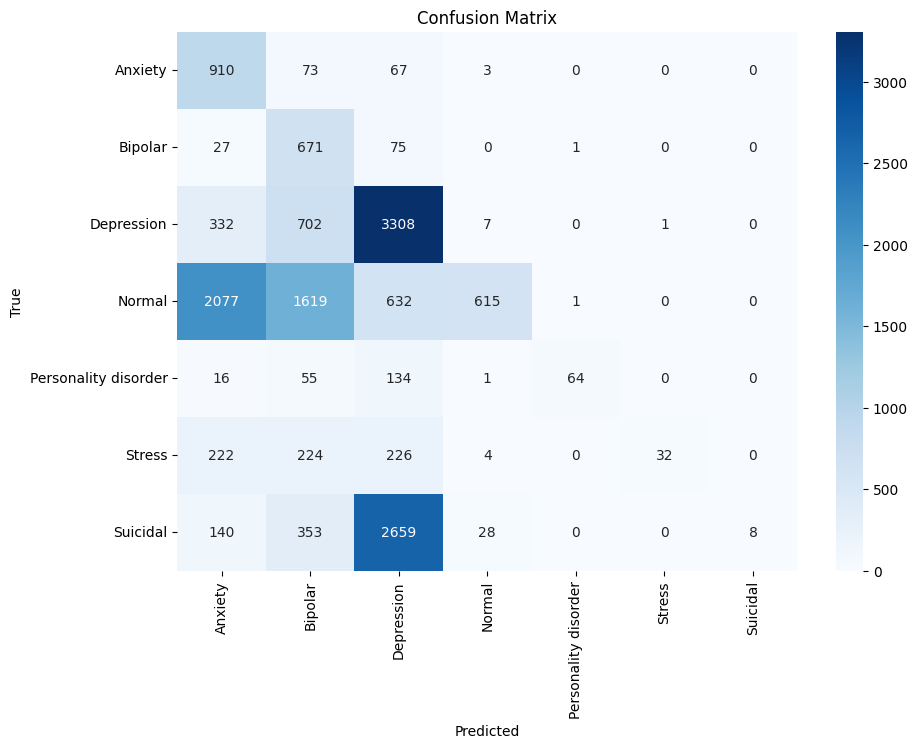

In [75]:
# Generate predictions on the test set
y_pred = best_model.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred, target_names=best_model.classes_)
print("Classification Report:\n", report)

# Optionally, print confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

These scores are not very good. Which is okay! We shall continue tuning!

Stress and Suicidal cases seem particularly hard to accurately predict, with lower f1-scores. We will keep this in mind as we tune and test other models...in case this seems to be a trend. 

We can come back to this model and tune it to yield better results...but first let's test some other models and see if they perform better as a baseline.

Before we move on, let's see whether there's any informative results on feature importance or irrelevancy, that we can highlight and compare with other models...We moved ahead and tried running other models like *XGBoost*, however they unsurprisingly didn't reach convergence due to extraneous computational runtimes. This makes sense, because our dataset is currently so large and complex with 7 target variables. We need to figure out how to narrow things down if possible.

We can trying **making lists of most and least important features across models**...then we can cross-reference using these lists and figure out which tokens to drop and which to keep as we hone in on feature selection.

## Feature Importance - MultinomialNB

Multinomial Bayes doesn't extract feature importance like some of our other predictive models...but we can still get some good idea of feature relevancy using log probabilities and extracting feature names. This will tell us the log of the probability that a particular word ends up in a feature class.

We'll have to extract from SelectKBest

In [76]:
# Accessing the TfidfVectorizer and SelectKBest from the pipeline
tfidf_vectorizer = best_model.named_steps['tfidf']
select_k_best = best_model.named_steps['feature_selection']  # Assuming 'feature_selection' is the name of SelectKBest step

# Getting feature names (words) from TfidfVectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get indices of selected features from SelectKBest
selected_feature_indices = select_k_best.get_support(indices=True)

# Accessing MultinomialNB classifier from the pipeline
clf = best_model.named_steps['clf']

# Getting the log probabilities of features given each class
log_probabilities = clf.feature_log_prob_

# Determine top and bottom features for all classes combined and store in combined lists
top_n = 50  # Number of top and bottom features to consider

multinomialnb_top_features = []
multinomialnb_bottom_features = []

for i, class_label in enumerate(clf.classes_):
    # Filter log_probabilities and feature_names with selected_feature_indices
    class_log_probabilities = log_probabilities[i, selected_feature_indices]
    class_feature_names = [feature_names[idx] for idx in selected_feature_indices]

    # Sort indices based on log probabilities
    top_features_idx = np.argsort(class_log_probabilities)[::-1][:top_n]
    bottom_features_idx = np.argsort(class_log_probabilities)[:top_n]

    # Retrieve top and bottom features
    top_features = [class_feature_names[idx] for idx in top_features_idx]
    bottom_features = [class_feature_names[idx] for idx in bottom_features_idx]

    multinomialnb_top_features.extend(top_features)
    multinomialnb_bottom_features.extend(bottom_features)

IndexError: index 1066 is out of bounds for axis 1 with size 1000

In [ ]:
multinomialnb_top_features

In [ ]:
multinomialnb_bottom_features

In [ ]:
# Print top 20 and bottom 20 features for each class individually
for i, class_label in enumerate(clf.classes_):
    # Filter log_probabilities and feature_names with selected_feature_indices
    class_log_probabilities = log_probabilities[i, selected_feature_indices]
    class_feature_names = [feature_names[idx] for idx in selected_feature_indices]

    # Sort indices based on log probabilities
    top_features_idx = np.argsort(class_log_probabilities)[::-1][:20]
    bottom_features_idx = np.argsort(class_log_probabilities)[:20]

    # Retrieve top and bottom features
    top_features = [class_feature_names[idx] for idx in top_features_idx]
    bottom_features = [class_feature_names[idx] for idx in bottom_features_idx]

    print(f"Top 20 features for class '{class_label}':")
    print(top_features)
    print()

    print(f"Bottom 20 features for class '{class_label}':")
    print(bottom_features)
    print()

Logistic Regression

# XGBoost

Let's try XGBoost, which is known to yield extraodinary results on large, complex datasets that require multi-categorical targets.

Let's train, test, split.

We can **include our numeric features** this time, in addition to our text data which will be vectorized.

# Define features and target
X = filtered_df.drop(columns=['status', 'tokens'])
y = filtered_df['status']  # 'status' is the target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#### LabelEncoder()

We need to use LabelEncoder() to make sure we have correctly formatted indices for XGBoost, starting at '0'.

y_train.value_counts().sort_index()

# Instantiate the encoder
encoder = LabelEncoder()

# Fit the encoder on y_train and transform it
y_train_encoded = encoder.fit_transform(y_train)

# Transform y_test based on the encoder fitted on y_train
y_test_encoded = encoder.transform(y_test)

# Convert back to pandas Series
y_train = pd.Series(y_train_encoded)
y_test = pd.Series(y_test_encoded)

# Check encoded labels
print("Encoded y_train:")
print(y_train.value_counts())

print("Encoded y_test:")
print(y_test.value_counts())

# Mapping from encoded labels to original labels
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print("Label Mapping:")
label_mapping

### Vectorize - TF-IDF

We need to vectorize our 'joined_tokens' again.

# Step 1: Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))

# Step 2: Transform text data
X_train_text = vectorizer.fit_transform(X_train['joined_tokens'])
X_test_text = vectorizer.transform(X_test['joined_tokens'])

X_train_numeric = X_train.drop(columns=['joined_tokens'])
X_test_numeric = X_test.drop(columns=['joined_tokens'])

X_train_numeric = X_train[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count']].values
X_test_numeric = X_test[['perc_upper_words', 'neg_emoji', 'exclamation_count', 'question_count']].values

# Step 3: Combine text and numeric features (if applicable)
# Assuming X_train_numeric and X_test_numeric are your numeric features
X_train_combined = hstack([X_train_text, X_train_numeric])
X_test_combined = hstack([X_test_text, X_test_numeric])

### Best Parameters - GridSearchCV

There are so many parameters we can test for...but we'll want to limit the number we run through GridSearchCV to cut down on computational cost. 

# Define the parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Initialize XGBClassifier
xgb_model = XGBClassifier(objective='multi:softmax', num_class=7, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_weighted',  # Use F1 score to account for class imbalance
    cv=5,  # Number of cross-validation folds
    verbose=0,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
grid_search.fit(X_train_combined, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_}")

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test set score: {test_score}")

# Convert numerical features to sparse matrix format
X_train_numerical = csr_matrix(X_train.drop(columns=['joined_tokens']).values)
X_test_numerical = csr_matrix(X_test.drop(columns=['joined_tokens']).values)

# Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_text, X_train_numerical])
X_test_combined = hstack([X_test_text, X_test_numerical])